<a href="https://colab.research.google.com/github/lukakukhaleishvili/shualeduri-2/blob/main/%E1%83%A8%E1%83%A3%E1%83%90%E1%83%9A%E1%83%94%E1%83%93%E1%83%A3%E1%83%A0%E1%83%98_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
#  2. მონაცემების მომზადება (CIFAR-10 ავტომატურად ჩაიტვირთება)

transform = transforms.Compose([
    transforms.ToTensor(),  # სურათი გადადის Tensor ფორმატში
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # ნორმალიზაცია [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True
)


In [12]:
#  3. ავტოენკოდერის არქიტექტურა

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder ნაწილი
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # → 16x16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # → 32x8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # → 64x4x4
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # → 128x2x2
            nn.ReLU()
        )

        # Decoder ნაწილი
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # → 64x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # → 32x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # → 16x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # → 3x32x32
            nn.Tanh()  # გამომავალი იქნება [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [5]:
# 4. მოწყობილობა (GPU თუ ხელმისაწვდომია)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("გამოიყენება მოწყობილობა:", device)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


გამოიყენება მოწყობილობა: cpu


In [26]:
#  5. მოდელის გაწვრთნა
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}")


Epoch 1/15, Loss: 0.0024
Epoch 2/15, Loss: 0.0024
Epoch 3/15, Loss: 0.0024
Epoch 4/15, Loss: 0.0023
Epoch 5/15, Loss: 0.0023
Epoch 6/15, Loss: 0.0023
Epoch 7/15, Loss: 0.0023
Epoch 8/15, Loss: 0.0022
Epoch 9/15, Loss: 0.0022
Epoch 10/15, Loss: 0.0022
Epoch 11/15, Loss: 0.0022
Epoch 12/15, Loss: 0.0022
Epoch 13/15, Loss: 0.0022
Epoch 14/15, Loss: 0.0021
Epoch 15/15, Loss: 0.0021


In [27]:
# 6. გამოსახულების ჩვენება
def unnormalize(img):
    return img * 0.5 + 0.5

def imshow(img):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.figure(figsize=(8, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

ორიგინალი გამოსახულებები


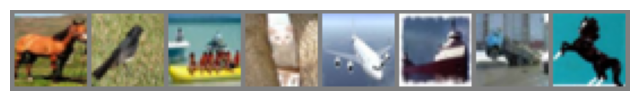

რეკონსტრუირებული გამოსახულებები


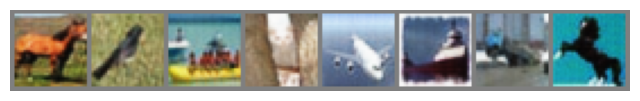

In [28]:
# 7. გამოსახულებების რეკონსტრუქცია
import numpy as np

# ამოვირჩიოთ რამდენიმე გამოსახულება სატესტო ვიზუალიზაციისთვის
sample_dataiter = iter(trainloader)
sample_images, _ = next(sample_dataiter)
sample_images = sample_images[:8].to(device)

# მოდელი გადაუშვება და რეკონსტრუქცია შესრულდება
reconstructed = model(sample_images).cpu().detach()

# ორიგინალი გამოსახულებები
print("ორიგინალი გამოსახულებები")
imshow(torchvision.utils.make_grid(sample_images.cpu()))

# რეკონსტრუირებული გამოსახულებები
print("რეკონსტრუირებული გამოსახულებები")
imshow(torchvision.utils.make_grid(reconstructed))


In [30]:
import torch.nn.functional as F

# მოდის საბოლოო განსხვავების გამოთვლა ნაჩვენებ გამოსახულებებს შორის
sample_images, _ = next(iter(trainloader))
sample_images = sample_images.to(device)

# რეკონსტრუქცია
with torch.no_grad():
    reconstructed = model(sample_images)

# ვიღებთ მხოლოდ იმ 8 სურათს, რაც გამოვაჩინეთ
sample_images_8 = sample_images[:8]
reconstructed_8 = reconstructed[:8]

# განსხვავების ფუნქცია
def reconstruction_difference(original, reconstructed):
    original = unnormalize(original)
    reconstructed = unnormalize(reconstructed)

    original = torch.clamp(original, 0, 1)
    reconstructed = torch.clamp(reconstructed, 0, 1)

    # Mean Absolute Error (L1)
    difference = F.l1_loss(reconstructed, original, reduction='mean')
    percent_diff = difference.item() * 100

    print(f"🔍 განსხვავება ნაჩვენებ სურათებს შორის: {percent_diff:.2f}%")
    return percent_diff

# გამოთვლა კონკრეტულად ნაჩვენებ გამოსახულებებზე
reconstruction_difference(sample_images_8, reconstructed_8)


🔍 განსხვავება ნაჩვენებ სურათებს შორის: 1.61%


1.6109617426991463